In [1]:
import ee
import os
import wxee as wx
# Set the path to the service account key file
service_account = 'editor@ee-manmeet20singh15-wbis.iam.gserviceaccount.com'
key_file = '//home/ms86336/Downloads/kaggle/ndui/ee-manmeet20singh15-wbis-fab7f1ca35e0.json'

# Use the service account for authentication
credentials = ee.ServiceAccountCredentials(service_account, key_file)
# ee.Initialize(credentials)

ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com', credentials=credentials)

In [3]:
import ee
import wxee
import xarray as xr

In [5]:
aoi = ee.Geometry.Polygon(
        [[[-97.7-0.1, 30.2672-0.1],
          [-97.7+0.1, 30.2672-0.1],
          [-97.7+0.1, 30.2672+0.1],
          [-97.7-0.1, 30.2672+0.1]
          ]]
)

In [6]:
# Define Pre-Flood and Post-Flood Dates
pre_flood_start_date = '2018-09-10'
pre_flood_end_date = '2018-09-21'
post_flood_start_date = '2018-09-22'
post_flood_end_date = '2018-09-30'

# Function to get image collection size for a given pass direction
def get_collection_size(pass_direction):
    pre_flood_collection = ee.ImageCollection('COPERNICUS/S1_GRD') \
        .filterBounds(aoi) \
        .filterDate(pre_flood_start_date, pre_flood_end_date) \
        .filter(ee.Filter.eq('instrumentMode', 'IW')) \
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')) \
        .filter(ee.Filter.eq('orbitProperties_pass', pass_direction))

    post_flood_collection = ee.ImageCollection('COPERNICUS/S1_GRD') \
        .filterBounds(aoi) \
        .filterDate(post_flood_start_date, post_flood_end_date) \
        .filter(ee.Filter.eq('instrumentMode', 'IW')) \
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')) \
        .filter(ee.Filter.eq('orbitProperties_pass', pass_direction))
    
    return pre_flood_collection.size().add(post_flood_collection.size())

# Get sizes for both pass directions
ascending_size = get_collection_size('ASCENDING')
descending_size = get_collection_size('DESCENDING')

# Determine the best pass direction
best_pass_direction = ee.String(
    ee.Algorithms.If(ascending_size.gt(descending_size), 'ASCENDING', 'DESCENDING')
).getInfo()

# Set Thresholds Based on the Selected Pass Direction
flood_threshold = 1.25 if best_pass_direction == 'ASCENDING' else -1.25

# Convert the threshold to an image
threshold_image = ee.Image.constant(flood_threshold)

# Filter Sentinel-1 Image Collection with the best pass direction
pre_flood_collection = ee.ImageCollection('COPERNICUS/S1_GRD') \
    .filterBounds(aoi) \
    .filterDate(pre_flood_start_date, pre_flood_end_date) \
    .filter(ee.Filter.eq('instrumentMode', 'IW')) \
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')) \
    .filter(ee.Filter.eq('orbitProperties_pass', best_pass_direction))

post_flood_collection = ee.ImageCollection('COPERNICUS/S1_GRD') \
    .filterBounds(aoi) \
    .filterDate(post_flood_start_date, post_flood_end_date) \
    .filter(ee.Filter.eq('instrumentMode', 'IW')) \
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')) \
    .filter(ee.Filter.eq('orbitProperties_pass', best_pass_direction))

# Create mosaic composites for pre- and post-flood
pre_flood_image = pre_flood_collection.mosaic().clip(aoi)
post_flood_image = post_flood_collection.mosaic().clip(aoi)

# Calculate the difference in VH band
vh_diff = post_flood_image.select('VH').subtract(pre_flood_image.select('VH')).rename('VH_Difference')

# Apply the threshold to identify flooded areas
flood_extent = vh_diff.lt(threshold_image).selfMask()


In [9]:
# Load DEM and calculate slope
DEM = ee.Image('WWF/HydroSHEDS/03VFDEM')
terrain = ee.Algorithms.Terrain(DEM)
slope = terrain.select('slope')

# Mask out areas with slope > 10%
slope_mask = slope.lte(10)
flood_extent_filtered = flood_extent.updateMask(slope_mask)

# Load the JRC Global Surface Water dataset to mask out permanent water bodies
jrc_water = ee.Image('JRC/GSW1_4/GlobalSurfaceWater') \
    .select('occurrence') \
    .clip(aoi)

permanent_water_mask = jrc_water.lt(10)  # Areas with water less than 10 months a year
flood_extent_filtered = flood_extent_filtered.updateMask(permanent_water_mask)

# Manually set a `system:time_start` property to the image to avoid MissingPropertyError
flood_extent_filtered = flood_extent_filtered.set('system:time_start', ee.Date(post_flood_start_date).millis())

# Convert the filtered flood extent image to an xarray dataset
flood_extent_filtered_xr = flood_extent_filtered.wx.to_xarray(scale=30, region=aoi.bounds())

Downloading:   0%|          | 0.00/7.54k [00:00<?, ?iB/s]

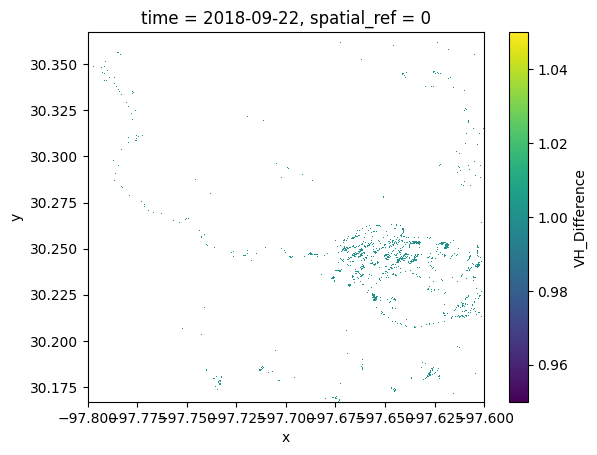

In [11]:
flood_extent_filtered_xr.VH_Difference.plot()

In [12]:
import datetime

In [13]:
# List of dates (converted to Python datetime objects)
dates = [
    '20141003', '20150131', '20150318', '20150401', '20150413', '20150425', '20150531',
    '20150624', '20150821', '20150916', '20150928', '20151115', '20151127', '20151209',
    '20151221', '20160114', '20160126', '20160407', '20160417', '20160419', '20160511',
    '20160523', '20160525', '20160604', '20160628', '20160710', '20160815', '20160817',
    '20160827', '20160926', '20161102', '20161103', '20161107', '20161203', '20170101',
    '20170102', '20170114', '20170118', '20170125', '20170126', '20170206', '20170207',
    '20170309', '20170327', '20170402', '20170508', '20170520', '20170526', '20170530',
    '20170601', '20170606', '20170619', '20170724', '20170725', '20170806', '20170824',
    '20171004', '20171116', '20171121', '20171122', '20171126', '20171203', '20171208',
    '20171216', '20171222', '20180101', '20180108', '20180121', '20180127', '20180201',
    '20180206', '20180208', '20180213', '20180214', '20180220', '20180225', '20180310',
    '20180316', '20180326', '20180328', '20180402', '20180407', '20180414', '20180421',
    '20180426', '20180503', '20180508', '20180515', '20180520', '20180521', '20180602',
    '20180608', '20180620', '20180625', '20180707', '20180708', '20180731', '20180812',
    '20180813', '20180817', '20180819', '20180905', '20180906', '20180910', '20180912',
    '20180922', '20180929', '20180930', '20181006', '20181016', '20181023', '20181024',
    '20181104', '20181109', '20181121', '20181123', '20181128', '20181129', '20181217',
    '20181222', '20181223', '20181227', '20181229', '20190103', '20190108', '20190115',
    '20190116', '20190122', '20190128', '20190203', '20190208', '20190209', '20190215',
    '20190221', '20190225', '20190309', '20190311', '20190316', '20190317', '20190323',
    '20190328', '20190421', '20190422', '20190503', '20190504', '20190508', '20190510',
    '20190515', '20190601', '20190613', '20190614', '20190615', '20190619', '20190620',
    '20190625', '20190626', '20190702', '20190703', '20190709', '20190715', '20190731',
    '20190814', '20190824', '20190901', '20190912', '20190913', '20190919', '20191001',
    '20191007', '20191011', '20191025', '20191030', '20191111', '20191112', '20191116',
    '20191128', '20191130', '20191205', '20191210', '20191212', '20191229', '20200110',
    '20200111', '20200117', '20200122', '20200203', '20200204', '20200210', '20200216',
    '20200222', '20200303', '20200310', '20200322', '20200327', '20200329', '20200403',
    '20200404', '20200408', '20200410', '20200422', '20200428', '20200502', '20200509',
    '20200514', '20200516', '20200521', '20200522', '20200526', '20200528', '20200602',
    '20200603', '20200614', '20200615', '20200626', '20200627', '20200720', '20200801',
    '20200802', '20200820', '20200906', '20200918', '20200919', '20201029', '20201031',
    '20201105', '20201206', '20201211', '20201212', '20201223', '20201230', '20210111',
    '20210129', '20210204', '20210210', '20210214', '20210216', '20210226', '20210228',
    '20210306', '20210310', '20210312', '20210317', '20210322', '20210324', '20210330',
    '20210403', '20210423', '20210427', '20210429', '20210504', '20210511', '20210516',
    '20210517', '20210523', '20210528', '20210529', '20210604', '20210622', '20210628',
    '20210703', '20210704', '20210708', '20210710', '20210715', '20210720', '20210722',
    '20210801', '20210803', '20210815', '20210827', '20210906', '20210908', '20210913',
    '20211012', '20211014', '20211020', '20211125', '20211206', '20211211', '20211218',
    '20211225', '20211230', '20220111', '20220216', '20220329', '20220410', '20220412',
    '20220417', '20220506', '20220511', '20220523', '20220604', '20220616', '20220628',
    '20220715', '20220722', '20220727', '20220808', '20220810', '20220815', '20220820',
    '20220822', '20220827', '20220901', '20220908', '20220927', '20221002', '20221007',
    '20221107', '20221114', '20221119', '20221124', '20221126', '20221213', '20221230',
    '20230111', '20230118', '20230130', '20230218', '20230302', '20230331', '20230405',
    '20230407', '20230429', '20230506', '20230513', '20230523', '20230525', '20230604',
    '20230606', '20230616', '20230618', '20230623', '20230705', '20230712', '20230810',
    '20230822', '20230910', '20230915', '20230927', '20231002', '20231004', '20231016',
    '20231021', '20231026', '20231028', '20231109', '20231201', '20231203', '20231213',
    '20231220', '20231225', '20240113', '20240125', '20240201', '20240211', '20240308',
    '20240313', '20240318', '20240325', '20240330', '20240401', '20240406', '20240411',
    '20240413', '20240418', '20240425', '20240505', '20240512', '20240517', '20240519',
    '20240524', '20240529', '20240531', '20240605', '20240610', '20240612', '20240617',
    '20240706', '20240718', '20240723', '20240728'
]

In [16]:
# Convert string dates to datetime objects
date_objects = [datetime.datetime.strptime(date, '%Y%m%d') for date in dates]

# Function to generate flood data using pre-flood and post-flood date ranges
def generate_flood_data(pre_flood_start_date, pre_flood_end_date, post_flood_start_date, post_flood_end_date, aoi):
    # Function to get image collection size for a given pass direction
    def get_collection_size(pass_direction):
        pre_flood_collection = ee.ImageCollection('COPERNICUS/S1_GRD') \
            .filterBounds(aoi) \
            .filterDate(pre_flood_start_date, pre_flood_end_date) \
            .filter(ee.Filter.eq('instrumentMode', 'IW')) \
            .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
            .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')) \
            .filter(ee.Filter.eq('orbitProperties_pass', pass_direction))

        post_flood_collection = ee.ImageCollection('COPERNICUS/S1_GRD') \
            .filterBounds(aoi) \
            .filterDate(post_flood_start_date, post_flood_end_date) \
            .filter(ee.Filter.eq('instrumentMode', 'IW')) \
            .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
            .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')) \
            .filter(ee.Filter.eq('orbitProperties_pass', pass_direction))
        
        return pre_flood_collection.size().add(post_flood_collection.size())

    # Get sizes for both pass directions
    ascending_size = get_collection_size('ASCENDING')
    descending_size = get_collection_size('DESCENDING')

    # Determine the best pass direction
    best_pass_direction = ee.String(
        ee.Algorithms.If(ascending_size.gt(descending_size), 'ASCENDING', 'DESCENDING')
    ).getInfo()

    # Set Thresholds Based on the Selected Pass Direction
    flood_threshold = 1.25 if best_pass_direction == 'ASCENDING' else -1.25

    # Convert the threshold to an image
    threshold_image = ee.Image.constant(flood_threshold)

    # Filter Sentinel-1 Image Collection with the best pass direction
    pre_flood_collection = ee.ImageCollection('COPERNICUS/S1_GRD') \
        .filterBounds(aoi) \
        .filterDate(pre_flood_start_date, pre_flood_end_date) \
        .filter(ee.Filter.eq('instrumentMode', 'IW')) \
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')) \
        .filter(ee.Filter.eq('orbitProperties_pass', best_pass_direction))

    post_flood_collection = ee.ImageCollection('COPERNICUS/S1_GRD') \
        .filterBounds(aoi) \
        .filterDate(post_flood_start_date, post_flood_end_date) \
        .filter(ee.Filter.eq('instrumentMode', 'IW')) \
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')) \
        .filter(ee.Filter.eq('orbitProperties_pass', best_pass_direction))

    # Create mosaic composites for pre- and post-flood
    pre_flood_image = pre_flood_collection.mosaic().clip(aoi)
    post_flood_image = post_flood_collection.mosaic().clip(aoi)

    # Calculate the difference in VH band
    vh_diff = post_flood_image.select('VH').subtract(pre_flood_image.select('VH')).rename('VH_Difference')

    # Apply the threshold to identify flooded areas
    flood_extent = vh_diff.lt(threshold_image).selfMask()

    # Load DEM and calculate slope
    DEM = ee.Image('WWF/HydroSHEDS/03VFDEM')
    terrain = ee.Algorithms.Terrain(DEM)
    slope = terrain.select('slope')

    # Mask out areas with slope > 10%
    slope_mask = slope.lte(10)
    flood_extent_filtered = flood_extent.updateMask(slope_mask)

    # Load the JRC Global Surface Water dataset to mask out permanent water bodies
    jrc_water = ee.Image('JRC/GSW1_4/GlobalSurfaceWater') \
        .select('occurrence') \
        .clip(aoi)

    permanent_water_mask = jrc_water.lt(10)  # Areas with water less than 10 months a year
    flood_extent_filtered = flood_extent_filtered.updateMask(permanent_water_mask)

    # Manually set a `system:time_start` property to the image to avoid MissingPropertyError
    flood_extent_filtered = flood_extent_filtered.set('system:time_start', ee.Date(post_flood_start_date).millis())

    # Convert the filtered flood extent image to an xarray dataset
    flood_extent_filtered_xr = flood_extent_filtered.wx.to_xarray(scale=30, region=aoi.bounds())

    # Save as NetCDF
    flood_extent_filtered_xr.to_netcdf(f'Refined_Flood_Extent_{post_flood_start_date}.nc')

# Automate date range selection for each date
for i in range(1, len(date_objects) - 1):
    try:
        post_flood_start_date = date_objects[i]
        pre_flood_end_date = post_flood_start_date - datetime.timedelta(days=1)
        pre_flood_start_date = pre_flood_end_date - datetime.timedelta(days=10)
        post_flood_end_date = post_flood_start_date + datetime.timedelta(days=10)

        # Convert datetime to string format for Earth Engine
        pre_flood_start_date_str = pre_flood_start_date.strftime('%Y-%m-%d')
        pre_flood_end_date_str = pre_flood_end_date.strftime('%Y-%m-%d')
        post_flood_start_date_str = post_flood_start_date.strftime('%Y-%m-%d')
        post_flood_end_date_str = post_flood_end_date.strftime('%Y-%m-%d')

        print(f"Processing pre-flood period: {pre_flood_start_date_str} to {pre_flood_end_date_str}")
        print(f"Processing post-flood period: {post_flood_start_date_str} to {post_flood_end_date_str}")

        # Generate flood data for the current date range
        generate_flood_data(pre_flood_start_date_str, pre_flood_end_date_str, post_flood_start_date_str, post_flood_end_date_str, aoi)
    except:
        continue

Processing pre-flood period: 2015-01-20 to 2015-01-30
Processing post-flood period: 2015-01-31 to 2015-02-10
Processing pre-flood period: 2015-03-07 to 2015-03-17
Processing post-flood period: 2015-03-18 to 2015-03-28
Processing pre-flood period: 2015-03-21 to 2015-03-31
Processing post-flood period: 2015-04-01 to 2015-04-11
Processing pre-flood period: 2015-04-02 to 2015-04-12
Processing post-flood period: 2015-04-13 to 2015-04-23
Processing pre-flood period: 2015-04-14 to 2015-04-24
Processing post-flood period: 2015-04-25 to 2015-05-05
Processing pre-flood period: 2015-05-20 to 2015-05-30
Processing post-flood period: 2015-05-31 to 2015-06-10
Processing pre-flood period: 2015-06-13 to 2015-06-23
Processing post-flood period: 2015-06-24 to 2015-07-04
Processing pre-flood period: 2015-08-10 to 2015-08-20
Processing post-flood period: 2015-08-21 to 2015-08-31
Processing pre-flood period: 2015-09-05 to 2015-09-15
Processing post-flood period: 2015-09-16 to 2015-09-26
Processing pre-floo

Downloading:   0%|          | 0.00/7.06k [00:00<?, ?iB/s]

Processing pre-flood period: 2016-10-22 to 2016-11-01
Processing post-flood period: 2016-11-02 to 2016-11-12


Downloading:   0%|          | 0.00/6.80k [00:00<?, ?iB/s]

Processing pre-flood period: 2016-10-23 to 2016-11-02
Processing post-flood period: 2016-11-03 to 2016-11-13


Downloading:   0%|          | 0.00/6.80k [00:00<?, ?iB/s]

Processing pre-flood period: 2016-10-27 to 2016-11-06
Processing post-flood period: 2016-11-07 to 2016-11-17
Processing pre-flood period: 2016-11-22 to 2016-12-02
Processing post-flood period: 2016-12-03 to 2016-12-13
Processing pre-flood period: 2016-12-21 to 2016-12-31
Processing post-flood period: 2017-01-01 to 2017-01-11


Downloading:   0%|          | 0.00/7.68k [00:00<?, ?iB/s]

Processing pre-flood period: 2016-12-22 to 2017-01-01
Processing post-flood period: 2017-01-02 to 2017-01-12


Downloading:   0%|          | 0.00/7.68k [00:00<?, ?iB/s]

Processing pre-flood period: 2017-01-03 to 2017-01-13
Processing post-flood period: 2017-01-14 to 2017-01-24


Downloading:   0%|          | 0.00/6.43k [00:00<?, ?iB/s]

Processing pre-flood period: 2017-01-07 to 2017-01-17
Processing post-flood period: 2017-01-18 to 2017-01-28
Processing pre-flood period: 2017-01-14 to 2017-01-24
Processing post-flood period: 2017-01-25 to 2017-02-04


Downloading:   0%|          | 0.00/7.79k [00:00<?, ?iB/s]

Processing pre-flood period: 2017-01-15 to 2017-01-25
Processing post-flood period: 2017-01-26 to 2017-02-05


Downloading:   0%|          | 0.00/7.79k [00:00<?, ?iB/s]

Processing pre-flood period: 2017-01-26 to 2017-02-05
Processing post-flood period: 2017-02-06 to 2017-02-16


Downloading:   0%|          | 0.00/7.34k [00:00<?, ?iB/s]

Processing pre-flood period: 2017-01-27 to 2017-02-06
Processing post-flood period: 2017-02-07 to 2017-02-17


Downloading:   0%|          | 0.00/7.34k [00:00<?, ?iB/s]

Processing pre-flood period: 2017-02-26 to 2017-03-08
Processing post-flood period: 2017-03-09 to 2017-03-19
Processing pre-flood period: 2017-03-16 to 2017-03-26
Processing post-flood period: 2017-03-27 to 2017-04-06


Downloading:   0%|          | 0.00/7.46k [00:00<?, ?iB/s]

Processing pre-flood period: 2017-03-22 to 2017-04-01
Processing post-flood period: 2017-04-02 to 2017-04-12
Processing pre-flood period: 2017-04-27 to 2017-05-07
Processing post-flood period: 2017-05-08 to 2017-05-18
Processing pre-flood period: 2017-05-09 to 2017-05-19
Processing post-flood period: 2017-05-20 to 2017-05-30
Processing pre-flood period: 2017-05-15 to 2017-05-25
Processing post-flood period: 2017-05-26 to 2017-06-05


Downloading:   0%|          | 0.00/7.08k [00:00<?, ?iB/s]

Processing pre-flood period: 2017-05-19 to 2017-05-29
Processing post-flood period: 2017-05-30 to 2017-06-09
Processing pre-flood period: 2017-05-21 to 2017-05-31
Processing post-flood period: 2017-06-01 to 2017-06-11
Processing pre-flood period: 2017-05-26 to 2017-06-05
Processing post-flood period: 2017-06-06 to 2017-06-16


Downloading:   0%|          | 0.00/7.56k [00:00<?, ?iB/s]

Processing pre-flood period: 2017-06-08 to 2017-06-18
Processing post-flood period: 2017-06-19 to 2017-06-29
Processing pre-flood period: 2017-07-13 to 2017-07-23
Processing post-flood period: 2017-07-24 to 2017-08-03


Downloading:   0%|          | 0.00/7.33k [00:00<?, ?iB/s]

Processing pre-flood period: 2017-07-14 to 2017-07-24
Processing post-flood period: 2017-07-25 to 2017-08-04


Downloading:   0%|          | 0.00/7.33k [00:00<?, ?iB/s]

Processing pre-flood period: 2017-07-26 to 2017-08-05
Processing post-flood period: 2017-08-06 to 2017-08-16
Processing pre-flood period: 2017-08-13 to 2017-08-23
Processing post-flood period: 2017-08-24 to 2017-09-03
Processing pre-flood period: 2017-09-23 to 2017-10-03
Processing post-flood period: 2017-10-04 to 2017-10-14
Processing pre-flood period: 2017-11-05 to 2017-11-15
Processing post-flood period: 2017-11-16 to 2017-11-26
Processing pre-flood period: 2017-11-10 to 2017-11-20
Processing post-flood period: 2017-11-21 to 2017-12-01


Downloading:   0%|          | 0.00/7.47k [00:00<?, ?iB/s]

Processing pre-flood period: 2017-11-11 to 2017-11-21
Processing post-flood period: 2017-11-22 to 2017-12-02


Downloading:   0%|          | 0.00/7.47k [00:00<?, ?iB/s]

Processing pre-flood period: 2017-11-15 to 2017-11-25
Processing post-flood period: 2017-11-26 to 2017-12-06
Processing pre-flood period: 2017-11-22 to 2017-12-02
Processing post-flood period: 2017-12-03 to 2017-12-13


Downloading:   0%|          | 0.00/6.60k [00:00<?, ?iB/s]

Processing pre-flood period: 2017-11-27 to 2017-12-07
Processing post-flood period: 2017-12-08 to 2017-12-18
Processing pre-flood period: 2017-12-05 to 2017-12-15
Processing post-flood period: 2017-12-16 to 2017-12-26
Processing pre-flood period: 2017-12-11 to 2017-12-21
Processing post-flood period: 2017-12-22 to 2018-01-01
Processing pre-flood period: 2017-12-21 to 2017-12-31
Processing post-flood period: 2018-01-01 to 2018-01-11
Processing pre-flood period: 2017-12-28 to 2018-01-07
Processing post-flood period: 2018-01-08 to 2018-01-18


Downloading:   0%|          | 0.00/7.52k [00:00<?, ?iB/s]

Processing pre-flood period: 2018-01-10 to 2018-01-20
Processing post-flood period: 2018-01-21 to 2018-01-31


Downloading:   0%|          | 0.00/7.58k [00:00<?, ?iB/s]

Processing pre-flood period: 2018-01-16 to 2018-01-26
Processing post-flood period: 2018-01-27 to 2018-02-06
Processing pre-flood period: 2018-01-21 to 2018-01-31
Processing post-flood period: 2018-02-01 to 2018-02-11


Downloading:   0%|          | 0.00/7.57k [00:00<?, ?iB/s]

Processing pre-flood period: 2018-01-26 to 2018-02-05
Processing post-flood period: 2018-02-06 to 2018-02-16
Processing pre-flood period: 2018-01-28 to 2018-02-07
Processing post-flood period: 2018-02-08 to 2018-02-18
Processing pre-flood period: 2018-02-02 to 2018-02-12
Processing post-flood period: 2018-02-13 to 2018-02-23


Downloading:   0%|          | 0.00/7.57k [00:00<?, ?iB/s]

Processing pre-flood period: 2018-02-03 to 2018-02-13
Processing post-flood period: 2018-02-14 to 2018-02-24


Downloading:   0%|          | 0.00/7.57k [00:00<?, ?iB/s]

Processing pre-flood period: 2018-02-09 to 2018-02-19
Processing post-flood period: 2018-02-20 to 2018-03-02
Processing pre-flood period: 2018-02-14 to 2018-02-24
Processing post-flood period: 2018-02-25 to 2018-03-07


Downloading:   0%|          | 0.00/7.26k [00:00<?, ?iB/s]

Processing pre-flood period: 2018-02-27 to 2018-03-09
Processing post-flood period: 2018-03-10 to 2018-03-20


Downloading:   0%|          | 0.00/7.54k [00:00<?, ?iB/s]

Processing pre-flood period: 2018-03-05 to 2018-03-15
Processing post-flood period: 2018-03-16 to 2018-03-26
Processing pre-flood period: 2018-03-15 to 2018-03-25
Processing post-flood period: 2018-03-26 to 2018-04-05
Processing pre-flood period: 2018-03-17 to 2018-03-27
Processing post-flood period: 2018-03-28 to 2018-04-07
Processing pre-flood period: 2018-03-22 to 2018-04-01
Processing post-flood period: 2018-04-02 to 2018-04-12


Downloading:   0%|          | 0.00/7.37k [00:00<?, ?iB/s]

Processing pre-flood period: 2018-03-27 to 2018-04-06
Processing post-flood period: 2018-04-07 to 2018-04-17
Processing pre-flood period: 2018-04-03 to 2018-04-13
Processing post-flood period: 2018-04-14 to 2018-04-24
Processing pre-flood period: 2018-04-10 to 2018-04-20
Processing post-flood period: 2018-04-21 to 2018-05-01
Processing pre-flood period: 2018-04-15 to 2018-04-25
Processing post-flood period: 2018-04-26 to 2018-05-06
Processing pre-flood period: 2018-04-22 to 2018-05-02
Processing post-flood period: 2018-05-03 to 2018-05-13
Processing pre-flood period: 2018-04-27 to 2018-05-07
Processing post-flood period: 2018-05-08 to 2018-05-18


Downloading:   0%|          | 0.00/7.32k [00:00<?, ?iB/s]

Processing pre-flood period: 2018-05-04 to 2018-05-14
Processing post-flood period: 2018-05-15 to 2018-05-25
Processing pre-flood period: 2018-05-09 to 2018-05-19
Processing post-flood period: 2018-05-20 to 2018-05-30


Downloading:   0%|          | 0.00/7.47k [00:00<?, ?iB/s]

Processing pre-flood period: 2018-05-10 to 2018-05-20
Processing post-flood period: 2018-05-21 to 2018-05-31


Downloading:   0%|          | 0.00/7.47k [00:00<?, ?iB/s]

Processing pre-flood period: 2018-05-22 to 2018-06-01
Processing post-flood period: 2018-06-02 to 2018-06-12
Processing pre-flood period: 2018-05-28 to 2018-06-07
Processing post-flood period: 2018-06-08 to 2018-06-18
Processing pre-flood period: 2018-06-09 to 2018-06-19
Processing post-flood period: 2018-06-20 to 2018-06-30
Processing pre-flood period: 2018-06-14 to 2018-06-24
Processing post-flood period: 2018-06-25 to 2018-07-05


Downloading:   0%|          | 0.00/7.43k [00:00<?, ?iB/s]

Processing pre-flood period: 2018-06-26 to 2018-07-06
Processing post-flood period: 2018-07-07 to 2018-07-17


Downloading:   0%|          | 0.00/7.23k [00:00<?, ?iB/s]

Processing pre-flood period: 2018-06-27 to 2018-07-07
Processing post-flood period: 2018-07-08 to 2018-07-18


Downloading:   0%|          | 0.00/7.23k [00:00<?, ?iB/s]

Processing pre-flood period: 2018-07-20 to 2018-07-30
Processing post-flood period: 2018-07-31 to 2018-08-10


Downloading:   0%|          | 0.00/7.54k [00:00<?, ?iB/s]

Processing pre-flood period: 2018-08-01 to 2018-08-11
Processing post-flood period: 2018-08-12 to 2018-08-22


Downloading:   0%|          | 0.00/7.30k [00:00<?, ?iB/s]

Processing pre-flood period: 2018-08-02 to 2018-08-12
Processing post-flood period: 2018-08-13 to 2018-08-23


Downloading:   0%|          | 0.00/7.30k [00:00<?, ?iB/s]

Processing pre-flood period: 2018-08-06 to 2018-08-16
Processing post-flood period: 2018-08-17 to 2018-08-27
Processing pre-flood period: 2018-08-08 to 2018-08-18
Processing post-flood period: 2018-08-19 to 2018-08-29
Processing pre-flood period: 2018-08-25 to 2018-09-04
Processing post-flood period: 2018-09-05 to 2018-09-15
Processing pre-flood period: 2018-08-26 to 2018-09-05
Processing post-flood period: 2018-09-06 to 2018-09-16
Processing pre-flood period: 2018-08-30 to 2018-09-09
Processing post-flood period: 2018-09-10 to 2018-09-20
Processing pre-flood period: 2018-09-01 to 2018-09-11
Processing post-flood period: 2018-09-12 to 2018-09-22
Processing pre-flood period: 2018-09-11 to 2018-09-21
Processing post-flood period: 2018-09-22 to 2018-10-02
Processing pre-flood period: 2018-09-18 to 2018-09-28
Processing post-flood period: 2018-09-29 to 2018-10-09


Downloading:   0%|          | 0.00/7.54k [00:00<?, ?iB/s]

Processing pre-flood period: 2018-09-19 to 2018-09-29
Processing post-flood period: 2018-09-30 to 2018-10-10


Downloading:   0%|          | 0.00/7.54k [00:00<?, ?iB/s]

Processing pre-flood period: 2018-09-25 to 2018-10-05
Processing post-flood period: 2018-10-06 to 2018-10-16
Processing pre-flood period: 2018-10-05 to 2018-10-15
Processing post-flood period: 2018-10-16 to 2018-10-26
Processing pre-flood period: 2018-10-12 to 2018-10-22
Processing post-flood period: 2018-10-23 to 2018-11-02
Processing pre-flood period: 2018-10-13 to 2018-10-23
Processing post-flood period: 2018-10-24 to 2018-11-03
Processing pre-flood period: 2018-10-24 to 2018-11-03
Processing post-flood period: 2018-11-04 to 2018-11-14


Downloading:   0%|          | 0.00/7.41k [00:00<?, ?iB/s]

Processing pre-flood period: 2018-10-29 to 2018-11-08
Processing post-flood period: 2018-11-09 to 2018-11-19
Processing pre-flood period: 2018-11-10 to 2018-11-20
Processing post-flood period: 2018-11-21 to 2018-12-01
Processing pre-flood period: 2018-11-12 to 2018-11-22
Processing post-flood period: 2018-11-23 to 2018-12-03
Processing pre-flood period: 2018-11-17 to 2018-11-27
Processing post-flood period: 2018-11-28 to 2018-12-08


Downloading:   0%|          | 0.00/7.40k [00:00<?, ?iB/s]

Processing pre-flood period: 2018-11-18 to 2018-11-28
Processing post-flood period: 2018-11-29 to 2018-12-09


Downloading:   0%|          | 0.00/7.40k [00:00<?, ?iB/s]

Processing pre-flood period: 2018-12-06 to 2018-12-16
Processing post-flood period: 2018-12-17 to 2018-12-27
Processing pre-flood period: 2018-12-11 to 2018-12-21
Processing post-flood period: 2018-12-22 to 2019-01-01
Processing pre-flood period: 2018-12-12 to 2018-12-22
Processing post-flood period: 2018-12-23 to 2019-01-02
Processing pre-flood period: 2018-12-16 to 2018-12-26
Processing post-flood period: 2018-12-27 to 2019-01-06
Processing pre-flood period: 2018-12-18 to 2018-12-28
Processing post-flood period: 2018-12-29 to 2019-01-08
Processing pre-flood period: 2018-12-23 to 2019-01-02
Processing post-flood period: 2019-01-03 to 2019-01-13


Downloading:   0%|          | 0.00/7.73k [00:00<?, ?iB/s]

Processing pre-flood period: 2018-12-28 to 2019-01-07
Processing post-flood period: 2019-01-08 to 2019-01-18
Processing pre-flood period: 2019-01-04 to 2019-01-14
Processing post-flood period: 2019-01-15 to 2019-01-25


Downloading:   0%|          | 0.00/7.42k [00:00<?, ?iB/s]

Processing pre-flood period: 2019-01-05 to 2019-01-15
Processing post-flood period: 2019-01-16 to 2019-01-26


Downloading:   0%|          | 0.00/7.42k [00:00<?, ?iB/s]

Processing pre-flood period: 2019-01-11 to 2019-01-21
Processing post-flood period: 2019-01-22 to 2019-02-01
Processing pre-flood period: 2019-01-17 to 2019-01-27
Processing post-flood period: 2019-01-28 to 2019-02-07


Downloading:   0%|          | 0.00/7.32k [00:00<?, ?iB/s]

Processing pre-flood period: 2019-01-23 to 2019-02-02
Processing post-flood period: 2019-02-03 to 2019-02-13
Processing pre-flood period: 2019-01-28 to 2019-02-07
Processing post-flood period: 2019-02-08 to 2019-02-18
Processing pre-flood period: 2019-01-29 to 2019-02-08
Processing post-flood period: 2019-02-09 to 2019-02-19
Processing pre-flood period: 2019-02-04 to 2019-02-14
Processing post-flood period: 2019-02-15 to 2019-02-25
Processing pre-flood period: 2019-02-10 to 2019-02-20
Processing post-flood period: 2019-02-21 to 2019-03-03
Processing pre-flood period: 2019-02-14 to 2019-02-24
Processing post-flood period: 2019-02-25 to 2019-03-07
Processing pre-flood period: 2019-02-26 to 2019-03-08
Processing post-flood period: 2019-03-09 to 2019-03-19
Processing pre-flood period: 2019-02-28 to 2019-03-10
Processing post-flood period: 2019-03-11 to 2019-03-21
Processing pre-flood period: 2019-03-05 to 2019-03-15
Processing post-flood period: 2019-03-16 to 2019-03-26


Downloading:   0%|          | 0.00/7.43k [00:00<?, ?iB/s]

Processing pre-flood period: 2019-03-06 to 2019-03-16
Processing post-flood period: 2019-03-17 to 2019-03-27


Downloading:   0%|          | 0.00/7.43k [00:00<?, ?iB/s]

Processing pre-flood period: 2019-03-12 to 2019-03-22
Processing post-flood period: 2019-03-23 to 2019-04-02
Processing pre-flood period: 2019-03-17 to 2019-03-27
Processing post-flood period: 2019-03-28 to 2019-04-07


Downloading:   0%|          | 0.00/7.58k [00:00<?, ?iB/s]

Processing pre-flood period: 2019-04-10 to 2019-04-20
Processing post-flood period: 2019-04-21 to 2019-05-01


Downloading:   0%|          | 0.00/7.32k [00:00<?, ?iB/s]

Processing pre-flood period: 2019-04-11 to 2019-04-21
Processing post-flood period: 2019-04-22 to 2019-05-02


Downloading:   0%|          | 0.00/7.32k [00:00<?, ?iB/s]

Processing pre-flood period: 2019-04-22 to 2019-05-02
Processing post-flood period: 2019-05-03 to 2019-05-13


Downloading:   0%|          | 0.00/7.36k [00:00<?, ?iB/s]

Processing pre-flood period: 2019-04-23 to 2019-05-03
Processing post-flood period: 2019-05-04 to 2019-05-14


Downloading:   0%|          | 0.00/7.36k [00:00<?, ?iB/s]

Processing pre-flood period: 2019-04-27 to 2019-05-07
Processing post-flood period: 2019-05-08 to 2019-05-18
Processing pre-flood period: 2019-04-29 to 2019-05-09
Processing post-flood period: 2019-05-10 to 2019-05-20
Processing pre-flood period: 2019-05-04 to 2019-05-14
Processing post-flood period: 2019-05-15 to 2019-05-25


Downloading:   0%|          | 0.00/7.40k [00:00<?, ?iB/s]

Processing pre-flood period: 2019-05-21 to 2019-05-31
Processing post-flood period: 2019-06-01 to 2019-06-11
Processing pre-flood period: 2019-06-02 to 2019-06-12
Processing post-flood period: 2019-06-13 to 2019-06-23
Processing pre-flood period: 2019-06-03 to 2019-06-13
Processing post-flood period: 2019-06-14 to 2019-06-24
Processing pre-flood period: 2019-06-04 to 2019-06-14
Processing post-flood period: 2019-06-15 to 2019-06-25


Downloading:   0%|          | 0.00/7.46k [00:00<?, ?iB/s]

Processing pre-flood period: 2019-06-08 to 2019-06-18
Processing post-flood period: 2019-06-19 to 2019-06-29


Downloading:   0%|          | 0.00/5.83k [00:00<?, ?iB/s]

Processing pre-flood period: 2019-06-09 to 2019-06-19
Processing post-flood period: 2019-06-20 to 2019-06-30


Downloading:   0%|          | 0.00/5.83k [00:00<?, ?iB/s]

Processing pre-flood period: 2019-06-14 to 2019-06-24
Processing post-flood period: 2019-06-25 to 2019-07-05


Downloading:   0%|          | 0.00/5.83k [00:00<?, ?iB/s]

Processing pre-flood period: 2019-06-15 to 2019-06-25
Processing post-flood period: 2019-06-26 to 2019-07-06


Downloading:   0%|          | 0.00/5.91k [00:00<?, ?iB/s]

Processing pre-flood period: 2019-06-21 to 2019-07-01
Processing post-flood period: 2019-07-02 to 2019-07-12


Downloading:   0%|          | 0.00/7.42k [00:00<?, ?iB/s]

Processing pre-flood period: 2019-06-22 to 2019-07-02
Processing post-flood period: 2019-07-03 to 2019-07-13


Downloading:   0%|          | 0.00/7.42k [00:00<?, ?iB/s]

Processing pre-flood period: 2019-06-28 to 2019-07-08
Processing post-flood period: 2019-07-09 to 2019-07-19
Processing pre-flood period: 2019-07-04 to 2019-07-14
Processing post-flood period: 2019-07-15 to 2019-07-25


Downloading:   0%|          | 0.00/7.42k [00:00<?, ?iB/s]

Processing pre-flood period: 2019-07-20 to 2019-07-30
Processing post-flood period: 2019-07-31 to 2019-08-10
Processing pre-flood period: 2019-08-03 to 2019-08-13
Processing post-flood period: 2019-08-14 to 2019-08-24
Processing pre-flood period: 2019-08-13 to 2019-08-23
Processing post-flood period: 2019-08-24 to 2019-09-03
Processing pre-flood period: 2019-08-21 to 2019-08-31
Processing post-flood period: 2019-09-01 to 2019-09-11


Downloading:   0%|          | 0.00/7.52k [00:00<?, ?iB/s]

Processing pre-flood period: 2019-09-01 to 2019-09-11
Processing post-flood period: 2019-09-12 to 2019-09-22


Downloading:   0%|          | 0.00/7.52k [00:00<?, ?iB/s]

Processing pre-flood period: 2019-09-02 to 2019-09-12
Processing post-flood period: 2019-09-13 to 2019-09-23


Downloading:   0%|          | 0.00/7.52k [00:00<?, ?iB/s]

Processing pre-flood period: 2019-09-08 to 2019-09-18
Processing post-flood period: 2019-09-19 to 2019-09-29
Processing pre-flood period: 2019-09-20 to 2019-09-30
Processing post-flood period: 2019-10-01 to 2019-10-11
Processing pre-flood period: 2019-09-26 to 2019-10-06
Processing post-flood period: 2019-10-07 to 2019-10-17


Downloading:   0%|          | 0.00/7.46k [00:00<?, ?iB/s]

Processing pre-flood period: 2019-09-30 to 2019-10-10
Processing post-flood period: 2019-10-11 to 2019-10-21
Processing pre-flood period: 2019-10-14 to 2019-10-24
Processing post-flood period: 2019-10-25 to 2019-11-04
Processing pre-flood period: 2019-10-19 to 2019-10-29
Processing post-flood period: 2019-10-30 to 2019-11-09


Downloading:   0%|          | 0.00/7.38k [00:00<?, ?iB/s]

Processing pre-flood period: 2019-10-31 to 2019-11-10
Processing post-flood period: 2019-11-11 to 2019-11-21


Downloading:   0%|          | 0.00/7.44k [00:00<?, ?iB/s]

Processing pre-flood period: 2019-11-01 to 2019-11-11
Processing post-flood period: 2019-11-12 to 2019-11-22


Downloading:   0%|          | 0.00/7.44k [00:00<?, ?iB/s]

Processing pre-flood period: 2019-11-05 to 2019-11-15
Processing post-flood period: 2019-11-16 to 2019-11-26
Processing pre-flood period: 2019-11-17 to 2019-11-27
Processing post-flood period: 2019-11-28 to 2019-12-08
Processing pre-flood period: 2019-11-19 to 2019-11-29
Processing post-flood period: 2019-11-30 to 2019-12-10
Processing pre-flood period: 2019-11-24 to 2019-12-04
Processing post-flood period: 2019-12-05 to 2019-12-15


Downloading:   0%|          | 0.00/7.40k [00:00<?, ?iB/s]

Processing pre-flood period: 2019-11-29 to 2019-12-09
Processing post-flood period: 2019-12-10 to 2019-12-20
Processing pre-flood period: 2019-12-01 to 2019-12-11
Processing post-flood period: 2019-12-12 to 2019-12-22
Processing pre-flood period: 2019-12-18 to 2019-12-28
Processing post-flood period: 2019-12-29 to 2020-01-08


Downloading:   0%|          | 0.00/7.48k [00:00<?, ?iB/s]

Processing pre-flood period: 2019-12-30 to 2020-01-09
Processing post-flood period: 2020-01-10 to 2020-01-20


Downloading:   0%|          | 0.00/6.79k [00:00<?, ?iB/s]

Processing pre-flood period: 2019-12-31 to 2020-01-10
Processing post-flood period: 2020-01-11 to 2020-01-21


Downloading:   0%|          | 0.00/6.79k [00:00<?, ?iB/s]

Processing pre-flood period: 2020-01-06 to 2020-01-16
Processing post-flood period: 2020-01-17 to 2020-01-27
Processing pre-flood period: 2020-01-11 to 2020-01-21
Processing post-flood period: 2020-01-22 to 2020-02-01


Downloading:   0%|          | 0.00/7.45k [00:00<?, ?iB/s]

Processing pre-flood period: 2020-01-23 to 2020-02-02
Processing post-flood period: 2020-02-03 to 2020-02-13


Downloading:   0%|          | 0.00/7.53k [00:00<?, ?iB/s]

Processing pre-flood period: 2020-01-24 to 2020-02-03
Processing post-flood period: 2020-02-04 to 2020-02-14


Downloading:   0%|          | 0.00/7.53k [00:00<?, ?iB/s]

Processing pre-flood period: 2020-01-30 to 2020-02-09
Processing post-flood period: 2020-02-10 to 2020-02-20
Processing pre-flood period: 2020-02-05 to 2020-02-15
Processing post-flood period: 2020-02-16 to 2020-02-26


Downloading:   0%|          | 0.00/6.96k [00:00<?, ?iB/s]

Processing pre-flood period: 2020-02-11 to 2020-02-21
Processing post-flood period: 2020-02-22 to 2020-03-03
Processing pre-flood period: 2020-02-21 to 2020-03-02
Processing post-flood period: 2020-03-03 to 2020-03-13
Processing pre-flood period: 2020-02-28 to 2020-03-09
Processing post-flood period: 2020-03-10 to 2020-03-20


Downloading:   0%|          | 0.00/7.33k [00:00<?, ?iB/s]

Processing pre-flood period: 2020-03-11 to 2020-03-21
Processing post-flood period: 2020-03-22 to 2020-04-01


Downloading:   0%|          | 0.00/7.36k [00:00<?, ?iB/s]

Processing pre-flood period: 2020-03-16 to 2020-03-26
Processing post-flood period: 2020-03-27 to 2020-04-06
Processing pre-flood period: 2020-03-18 to 2020-03-28
Processing post-flood period: 2020-03-29 to 2020-04-08
Processing pre-flood period: 2020-03-23 to 2020-04-02
Processing post-flood period: 2020-04-03 to 2020-04-13


Downloading:   0%|          | 0.00/7.39k [00:00<?, ?iB/s]

Processing pre-flood period: 2020-03-24 to 2020-04-03
Processing post-flood period: 2020-04-04 to 2020-04-14


Downloading:   0%|          | 0.00/7.39k [00:00<?, ?iB/s]

Processing pre-flood period: 2020-03-28 to 2020-04-07
Processing post-flood period: 2020-04-08 to 2020-04-18
Processing pre-flood period: 2020-03-30 to 2020-04-09
Processing post-flood period: 2020-04-10 to 2020-04-20
Processing pre-flood period: 2020-04-11 to 2020-04-21
Processing post-flood period: 2020-04-22 to 2020-05-02
Processing pre-flood period: 2020-04-17 to 2020-04-27
Processing post-flood period: 2020-04-28 to 2020-05-08


Downloading:   0%|          | 0.00/7.54k [00:00<?, ?iB/s]

Processing pre-flood period: 2020-04-21 to 2020-05-01
Processing post-flood period: 2020-05-02 to 2020-05-12
Processing pre-flood period: 2020-04-28 to 2020-05-08
Processing post-flood period: 2020-05-09 to 2020-05-19


Downloading:   0%|          | 0.00/7.22k [00:00<?, ?iB/s]

Processing pre-flood period: 2020-05-03 to 2020-05-13
Processing post-flood period: 2020-05-14 to 2020-05-24
Processing pre-flood period: 2020-05-05 to 2020-05-15
Processing post-flood period: 2020-05-16 to 2020-05-26
Processing pre-flood period: 2020-05-10 to 2020-05-20
Processing post-flood period: 2020-05-21 to 2020-05-31


Downloading:   0%|          | 0.00/7.48k [00:00<?, ?iB/s]

Processing pre-flood period: 2020-05-11 to 2020-05-21
Processing post-flood period: 2020-05-22 to 2020-06-01


Downloading:   0%|          | 0.00/7.48k [00:00<?, ?iB/s]

Processing pre-flood period: 2020-05-15 to 2020-05-25
Processing post-flood period: 2020-05-26 to 2020-06-05
Processing pre-flood period: 2020-05-17 to 2020-05-27
Processing post-flood period: 2020-05-28 to 2020-06-07
Processing pre-flood period: 2020-05-22 to 2020-06-01
Processing post-flood period: 2020-06-02 to 2020-06-12


Downloading:   0%|          | 0.00/7.56k [00:00<?, ?iB/s]

Processing pre-flood period: 2020-05-23 to 2020-06-02
Processing post-flood period: 2020-06-03 to 2020-06-13


Downloading:   0%|          | 0.00/7.56k [00:00<?, ?iB/s]

Processing pre-flood period: 2020-06-03 to 2020-06-13
Processing post-flood period: 2020-06-14 to 2020-06-24


Downloading:   0%|          | 0.00/7.56k [00:00<?, ?iB/s]

Processing pre-flood period: 2020-06-04 to 2020-06-14
Processing post-flood period: 2020-06-15 to 2020-06-25


Downloading:   0%|          | 0.00/7.56k [00:00<?, ?iB/s]

Processing pre-flood period: 2020-06-15 to 2020-06-25
Processing post-flood period: 2020-06-26 to 2020-07-06


Downloading:   0%|          | 0.00/7.26k [00:00<?, ?iB/s]

Processing pre-flood period: 2020-06-16 to 2020-06-26
Processing post-flood period: 2020-06-27 to 2020-07-07


Downloading:   0%|          | 0.00/7.26k [00:00<?, ?iB/s]

Processing pre-flood period: 2020-07-09 to 2020-07-19
Processing post-flood period: 2020-07-20 to 2020-07-30


Downloading:   0%|          | 0.00/7.54k [00:00<?, ?iB/s]

Processing pre-flood period: 2020-07-21 to 2020-07-31
Processing post-flood period: 2020-08-01 to 2020-08-11


Downloading:   0%|          | 0.00/7.46k [00:00<?, ?iB/s]

Processing pre-flood period: 2020-07-22 to 2020-08-01
Processing post-flood period: 2020-08-02 to 2020-08-12


Downloading:   0%|          | 0.00/7.46k [00:00<?, ?iB/s]

Processing pre-flood period: 2020-08-09 to 2020-08-19
Processing post-flood period: 2020-08-20 to 2020-08-30
Processing pre-flood period: 2020-08-26 to 2020-09-05
Processing post-flood period: 2020-09-06 to 2020-09-16


Downloading:   0%|          | 0.00/7.14k [00:00<?, ?iB/s]

Processing pre-flood period: 2020-09-07 to 2020-09-17
Processing post-flood period: 2020-09-18 to 2020-09-28


Downloading:   0%|          | 0.00/7.36k [00:00<?, ?iB/s]

Processing pre-flood period: 2020-09-08 to 2020-09-18
Processing post-flood period: 2020-09-19 to 2020-09-29


Downloading:   0%|          | 0.00/7.36k [00:00<?, ?iB/s]

Processing pre-flood period: 2020-10-18 to 2020-10-28
Processing post-flood period: 2020-10-29 to 2020-11-08
Processing pre-flood period: 2020-10-20 to 2020-10-30
Processing post-flood period: 2020-10-31 to 2020-11-10
Processing pre-flood period: 2020-10-25 to 2020-11-04
Processing post-flood period: 2020-11-05 to 2020-11-15


Downloading:   0%|          | 0.00/7.33k [00:00<?, ?iB/s]

Processing pre-flood period: 2020-11-25 to 2020-12-05
Processing post-flood period: 2020-12-06 to 2020-12-16
Processing pre-flood period: 2020-11-30 to 2020-12-10
Processing post-flood period: 2020-12-11 to 2020-12-21


Downloading:   0%|          | 0.00/7.59k [00:00<?, ?iB/s]

Processing pre-flood period: 2020-12-01 to 2020-12-11
Processing post-flood period: 2020-12-12 to 2020-12-22


Downloading:   0%|          | 0.00/7.59k [00:00<?, ?iB/s]

Processing pre-flood period: 2020-12-12 to 2020-12-22
Processing post-flood period: 2020-12-23 to 2021-01-02


Downloading:   0%|          | 0.00/7.47k [00:00<?, ?iB/s]

Processing pre-flood period: 2020-12-19 to 2020-12-29
Processing post-flood period: 2020-12-30 to 2021-01-09
Processing pre-flood period: 2020-12-31 to 2021-01-10
Processing post-flood period: 2021-01-11 to 2021-01-21
Processing pre-flood period: 2021-01-18 to 2021-01-28
Processing post-flood period: 2021-01-29 to 2021-02-08


Downloading:   0%|          | 0.00/7.43k [00:00<?, ?iB/s]

Processing pre-flood period: 2021-01-24 to 2021-02-03
Processing post-flood period: 2021-02-04 to 2021-02-14
Processing pre-flood period: 2021-01-30 to 2021-02-09
Processing post-flood period: 2021-02-10 to 2021-02-20


Downloading:   0%|          | 0.00/7.56k [00:00<?, ?iB/s]

Processing pre-flood period: 2021-02-03 to 2021-02-13
Processing post-flood period: 2021-02-14 to 2021-02-24
Processing pre-flood period: 2021-02-05 to 2021-02-15
Processing post-flood period: 2021-02-16 to 2021-02-26
Processing pre-flood period: 2021-02-15 to 2021-02-25
Processing post-flood period: 2021-02-26 to 2021-03-08
Processing pre-flood period: 2021-02-17 to 2021-02-27
Processing post-flood period: 2021-02-28 to 2021-03-10
Processing pre-flood period: 2021-02-23 to 2021-03-05
Processing post-flood period: 2021-03-06 to 2021-03-16


Downloading:   0%|          | 0.00/7.33k [00:00<?, ?iB/s]

Processing pre-flood period: 2021-02-27 to 2021-03-09
Processing post-flood period: 2021-03-10 to 2021-03-20
Processing pre-flood period: 2021-03-01 to 2021-03-11
Processing post-flood period: 2021-03-12 to 2021-03-22
Processing pre-flood period: 2021-03-06 to 2021-03-16
Processing post-flood period: 2021-03-17 to 2021-03-27


Downloading:   0%|          | 0.00/7.42k [00:00<?, ?iB/s]

Processing pre-flood period: 2021-03-11 to 2021-03-21
Processing post-flood period: 2021-03-22 to 2021-04-01
Processing pre-flood period: 2021-03-13 to 2021-03-23
Processing post-flood period: 2021-03-24 to 2021-04-03
Processing pre-flood period: 2021-03-19 to 2021-03-29
Processing post-flood period: 2021-03-30 to 2021-04-09


Downloading:   0%|          | 0.00/7.55k [00:00<?, ?iB/s]

Processing pre-flood period: 2021-03-23 to 2021-04-02
Processing post-flood period: 2021-04-03 to 2021-04-13
Processing pre-flood period: 2021-04-12 to 2021-04-22
Processing post-flood period: 2021-04-23 to 2021-05-03
Processing pre-flood period: 2021-04-16 to 2021-04-26
Processing post-flood period: 2021-04-27 to 2021-05-07
Processing pre-flood period: 2021-04-18 to 2021-04-28
Processing post-flood period: 2021-04-29 to 2021-05-09
Processing pre-flood period: 2021-04-23 to 2021-05-03
Processing post-flood period: 2021-05-04 to 2021-05-14


Downloading:   0%|          | 0.00/7.18k [00:00<?, ?iB/s]

Processing pre-flood period: 2021-04-30 to 2021-05-10
Processing post-flood period: 2021-05-11 to 2021-05-21
Processing pre-flood period: 2021-05-05 to 2021-05-15
Processing post-flood period: 2021-05-16 to 2021-05-26


Downloading:   0%|          | 0.00/7.36k [00:00<?, ?iB/s]

Processing pre-flood period: 2021-05-06 to 2021-05-16
Processing post-flood period: 2021-05-17 to 2021-05-27


Downloading:   0%|          | 0.00/7.36k [00:00<?, ?iB/s]

Processing pre-flood period: 2021-05-12 to 2021-05-22
Processing post-flood period: 2021-05-23 to 2021-06-02
Processing pre-flood period: 2021-05-17 to 2021-05-27
Processing post-flood period: 2021-05-28 to 2021-06-07


Downloading:   0%|          | 0.00/7.35k [00:00<?, ?iB/s]

Processing pre-flood period: 2021-05-18 to 2021-05-28
Processing post-flood period: 2021-05-29 to 2021-06-08


Downloading:   0%|          | 0.00/7.35k [00:00<?, ?iB/s]

Processing pre-flood period: 2021-05-24 to 2021-06-03
Processing post-flood period: 2021-06-04 to 2021-06-14
Processing pre-flood period: 2021-06-11 to 2021-06-21
Processing post-flood period: 2021-06-22 to 2021-07-02


Downloading:   0%|          | 0.00/7.40k [00:00<?, ?iB/s]

Processing pre-flood period: 2021-06-17 to 2021-06-27
Processing post-flood period: 2021-06-28 to 2021-07-08
Processing pre-flood period: 2021-06-22 to 2021-07-02
Processing post-flood period: 2021-07-03 to 2021-07-13


Downloading:   0%|          | 0.00/7.31k [00:00<?, ?iB/s]

Processing pre-flood period: 2021-06-23 to 2021-07-03
Processing post-flood period: 2021-07-04 to 2021-07-14


Downloading:   0%|          | 0.00/7.31k [00:00<?, ?iB/s]

Processing pre-flood period: 2021-06-27 to 2021-07-07
Processing post-flood period: 2021-07-08 to 2021-07-18
Processing pre-flood period: 2021-06-29 to 2021-07-09
Processing post-flood period: 2021-07-10 to 2021-07-20
Processing pre-flood period: 2021-07-04 to 2021-07-14
Processing post-flood period: 2021-07-15 to 2021-07-25


Downloading:   0%|          | 0.00/6.84k [00:00<?, ?iB/s]

Processing pre-flood period: 2021-07-09 to 2021-07-19
Processing post-flood period: 2021-07-20 to 2021-07-30
Processing pre-flood period: 2021-07-11 to 2021-07-21
Processing post-flood period: 2021-07-22 to 2021-08-01
Processing pre-flood period: 2021-07-21 to 2021-07-31
Processing post-flood period: 2021-08-01 to 2021-08-11
Processing pre-flood period: 2021-07-23 to 2021-08-02
Processing post-flood period: 2021-08-03 to 2021-08-13
Processing pre-flood period: 2021-08-04 to 2021-08-14
Processing post-flood period: 2021-08-15 to 2021-08-25
Processing pre-flood period: 2021-08-16 to 2021-08-26
Processing post-flood period: 2021-08-27 to 2021-09-06
Processing pre-flood period: 2021-08-26 to 2021-09-05
Processing post-flood period: 2021-09-06 to 2021-09-16
Processing pre-flood period: 2021-08-28 to 2021-09-07
Processing post-flood period: 2021-09-08 to 2021-09-18
Processing pre-flood period: 2021-09-02 to 2021-09-12
Processing post-flood period: 2021-09-13 to 2021-09-23


Downloading:   0%|          | 0.00/7.44k [00:00<?, ?iB/s]

Processing pre-flood period: 2021-10-01 to 2021-10-11
Processing post-flood period: 2021-10-12 to 2021-10-22
Processing pre-flood period: 2021-10-03 to 2021-10-13
Processing post-flood period: 2021-10-14 to 2021-10-24
Processing pre-flood period: 2021-10-09 to 2021-10-19
Processing post-flood period: 2021-10-20 to 2021-10-30


Downloading:   0%|          | 0.00/7.45k [00:00<?, ?iB/s]

Processing pre-flood period: 2021-11-14 to 2021-11-24
Processing post-flood period: 2021-11-25 to 2021-12-05


Downloading:   0%|          | 0.00/7.42k [00:00<?, ?iB/s]

Processing pre-flood period: 2021-11-25 to 2021-12-05
Processing post-flood period: 2021-12-06 to 2021-12-16


Downloading:   0%|          | 0.00/7.43k [00:00<?, ?iB/s]

Processing pre-flood period: 2021-11-30 to 2021-12-10
Processing post-flood period: 2021-12-11 to 2021-12-21
Processing pre-flood period: 2021-12-07 to 2021-12-17
Processing post-flood period: 2021-12-18 to 2021-12-28


Downloading:   0%|          | 0.00/7.56k [00:00<?, ?iB/s]

Processing pre-flood period: 2021-12-14 to 2021-12-24
Processing post-flood period: 2021-12-25 to 2022-01-04
Processing pre-flood period: 2021-12-19 to 2021-12-29
Processing post-flood period: 2021-12-30 to 2022-01-09


Downloading:   0%|          | 0.00/7.70k [00:00<?, ?iB/s]

Processing pre-flood period: 2021-12-31 to 2022-01-10
Processing post-flood period: 2022-01-11 to 2022-01-21


Downloading:   0%|          | 0.00/7.46k [00:00<?, ?iB/s]

Processing pre-flood period: 2022-02-05 to 2022-02-15
Processing post-flood period: 2022-02-16 to 2022-02-26


Downloading:   0%|          | 0.00/7.53k [00:00<?, ?iB/s]

Processing pre-flood period: 2022-03-18 to 2022-03-28
Processing post-flood period: 2022-03-29 to 2022-04-08
Processing pre-flood period: 2022-03-30 to 2022-04-09
Processing post-flood period: 2022-04-10 to 2022-04-20
Processing pre-flood period: 2022-04-01 to 2022-04-11
Processing post-flood period: 2022-04-12 to 2022-04-22
Processing pre-flood period: 2022-04-06 to 2022-04-16
Processing post-flood period: 2022-04-17 to 2022-04-27


Downloading:   0%|          | 0.00/7.55k [00:00<?, ?iB/s]

Processing pre-flood period: 2022-04-25 to 2022-05-05
Processing post-flood period: 2022-05-06 to 2022-05-16
Processing pre-flood period: 2022-04-30 to 2022-05-10
Processing post-flood period: 2022-05-11 to 2022-05-21


Downloading:   0%|          | 0.00/7.41k [00:00<?, ?iB/s]

Processing pre-flood period: 2022-05-12 to 2022-05-22
Processing post-flood period: 2022-05-23 to 2022-06-02


Downloading:   0%|          | 0.00/7.31k [00:00<?, ?iB/s]

Processing pre-flood period: 2022-05-24 to 2022-06-03
Processing post-flood period: 2022-06-04 to 2022-06-14


Downloading:   0%|          | 0.00/7.62k [00:00<?, ?iB/s]

Processing pre-flood period: 2022-06-05 to 2022-06-15
Processing post-flood period: 2022-06-16 to 2022-06-26


Downloading:   0%|          | 0.00/7.51k [00:00<?, ?iB/s]

Processing pre-flood period: 2022-06-17 to 2022-06-27
Processing post-flood period: 2022-06-28 to 2022-07-08


Downloading:   0%|          | 0.00/7.47k [00:00<?, ?iB/s]

Processing pre-flood period: 2022-07-04 to 2022-07-14
Processing post-flood period: 2022-07-15 to 2022-07-25
Processing pre-flood period: 2022-07-11 to 2022-07-21
Processing post-flood period: 2022-07-22 to 2022-08-01


Downloading:   0%|          | 0.00/7.30k [00:00<?, ?iB/s]

Processing pre-flood period: 2022-07-16 to 2022-07-26
Processing post-flood period: 2022-07-27 to 2022-08-06
Processing pre-flood period: 2022-07-28 to 2022-08-07
Processing post-flood period: 2022-08-08 to 2022-08-18
Processing pre-flood period: 2022-07-30 to 2022-08-09
Processing post-flood period: 2022-08-10 to 2022-08-20
Processing pre-flood period: 2022-08-04 to 2022-08-14
Processing post-flood period: 2022-08-15 to 2022-08-25


Downloading:   0%|          | 0.00/6.62k [00:00<?, ?iB/s]

Processing pre-flood period: 2022-08-09 to 2022-08-19
Processing post-flood period: 2022-08-20 to 2022-08-30
Processing pre-flood period: 2022-08-11 to 2022-08-21
Processing post-flood period: 2022-08-22 to 2022-09-01
Processing pre-flood period: 2022-08-16 to 2022-08-26
Processing post-flood period: 2022-08-27 to 2022-09-06


Downloading:   0%|          | 0.00/7.66k [00:00<?, ?iB/s]

Processing pre-flood period: 2022-08-21 to 2022-08-31
Processing post-flood period: 2022-09-01 to 2022-09-11
Processing pre-flood period: 2022-08-28 to 2022-09-07
Processing post-flood period: 2022-09-08 to 2022-09-18


Downloading:   0%|          | 0.00/7.44k [00:00<?, ?iB/s]

Processing pre-flood period: 2022-09-16 to 2022-09-26
Processing post-flood period: 2022-09-27 to 2022-10-07
Processing pre-flood period: 2022-09-21 to 2022-10-01
Processing post-flood period: 2022-10-02 to 2022-10-12


Downloading:   0%|          | 0.00/7.66k [00:00<?, ?iB/s]

Processing pre-flood period: 2022-09-26 to 2022-10-06
Processing post-flood period: 2022-10-07 to 2022-10-17
Processing pre-flood period: 2022-10-27 to 2022-11-06
Processing post-flood period: 2022-11-07 to 2022-11-17


Downloading:   0%|          | 0.00/7.14k [00:00<?, ?iB/s]

Processing pre-flood period: 2022-11-03 to 2022-11-13
Processing post-flood period: 2022-11-14 to 2022-11-24
Processing pre-flood period: 2022-11-08 to 2022-11-18
Processing post-flood period: 2022-11-19 to 2022-11-29


Downloading:   0%|          | 0.00/7.62k [00:00<?, ?iB/s]

Processing pre-flood period: 2022-11-13 to 2022-11-23
Processing post-flood period: 2022-11-24 to 2022-12-04
Processing pre-flood period: 2022-11-15 to 2022-11-25
Processing post-flood period: 2022-11-26 to 2022-12-06
Processing pre-flood period: 2022-12-02 to 2022-12-12
Processing post-flood period: 2022-12-13 to 2022-12-23
Processing pre-flood period: 2022-12-19 to 2022-12-29
Processing post-flood period: 2022-12-30 to 2023-01-09
Processing pre-flood period: 2022-12-31 to 2023-01-10
Processing post-flood period: 2023-01-11 to 2023-01-21
Processing pre-flood period: 2023-01-07 to 2023-01-17
Processing post-flood period: 2023-01-18 to 2023-01-28


Downloading:   0%|          | 0.00/7.64k [00:00<?, ?iB/s]

Processing pre-flood period: 2023-01-19 to 2023-01-29
Processing post-flood period: 2023-01-30 to 2023-02-09


Downloading:   0%|          | 0.00/6.88k [00:00<?, ?iB/s]

Processing pre-flood period: 2023-02-07 to 2023-02-17
Processing post-flood period: 2023-02-18 to 2023-02-28
Processing pre-flood period: 2023-02-19 to 2023-03-01
Processing post-flood period: 2023-03-02 to 2023-03-12
Processing pre-flood period: 2023-03-20 to 2023-03-30
Processing post-flood period: 2023-03-31 to 2023-04-10


Downloading:   0%|          | 0.00/7.61k [00:00<?, ?iB/s]

Processing pre-flood period: 2023-03-25 to 2023-04-04
Processing post-flood period: 2023-04-05 to 2023-04-15
Processing pre-flood period: 2023-03-27 to 2023-04-06
Processing post-flood period: 2023-04-07 to 2023-04-17
Processing pre-flood period: 2023-04-18 to 2023-04-28
Processing post-flood period: 2023-04-29 to 2023-05-09
Processing pre-flood period: 2023-04-25 to 2023-05-05
Processing post-flood period: 2023-05-06 to 2023-05-16


Downloading:   0%|          | 0.00/7.64k [00:00<?, ?iB/s]

Processing pre-flood period: 2023-05-02 to 2023-05-12
Processing post-flood period: 2023-05-13 to 2023-05-23
Processing pre-flood period: 2023-05-12 to 2023-05-22
Processing post-flood period: 2023-05-23 to 2023-06-02
Processing pre-flood period: 2023-05-14 to 2023-05-24
Processing post-flood period: 2023-05-25 to 2023-06-04
Processing pre-flood period: 2023-05-24 to 2023-06-03
Processing post-flood period: 2023-06-04 to 2023-06-14
Processing pre-flood period: 2023-05-26 to 2023-06-05
Processing post-flood period: 2023-06-06 to 2023-06-16
Processing pre-flood period: 2023-06-05 to 2023-06-15
Processing post-flood period: 2023-06-16 to 2023-06-26
Processing pre-flood period: 2023-06-07 to 2023-06-17
Processing post-flood period: 2023-06-18 to 2023-06-28
Processing pre-flood period: 2023-06-12 to 2023-06-22
Processing post-flood period: 2023-06-23 to 2023-07-03


Downloading:   0%|          | 0.00/7.46k [00:00<?, ?iB/s]

Processing pre-flood period: 2023-06-24 to 2023-07-04
Processing post-flood period: 2023-07-05 to 2023-07-15


Downloading:   0%|          | 0.00/7.41k [00:00<?, ?iB/s]

Processing pre-flood period: 2023-07-01 to 2023-07-11
Processing post-flood period: 2023-07-12 to 2023-07-22
Processing pre-flood period: 2023-07-30 to 2023-08-09
Processing post-flood period: 2023-08-10 to 2023-08-20
Processing pre-flood period: 2023-08-11 to 2023-08-21
Processing post-flood period: 2023-08-22 to 2023-09-01


Downloading:   0%|          | 0.00/7.46k [00:00<?, ?iB/s]

Processing pre-flood period: 2023-08-30 to 2023-09-09
Processing post-flood period: 2023-09-10 to 2023-09-20
Processing pre-flood period: 2023-09-04 to 2023-09-14
Processing post-flood period: 2023-09-15 to 2023-09-25
Processing pre-flood period: 2023-09-16 to 2023-09-26
Processing post-flood period: 2023-09-27 to 2023-10-07


Downloading:   0%|          | 0.00/7.45k [00:00<?, ?iB/s]

Processing pre-flood period: 2023-09-21 to 2023-10-01
Processing post-flood period: 2023-10-02 to 2023-10-12
Processing pre-flood period: 2023-09-23 to 2023-10-03
Processing post-flood period: 2023-10-04 to 2023-10-14
Processing pre-flood period: 2023-10-05 to 2023-10-15
Processing post-flood period: 2023-10-16 to 2023-10-26
Processing pre-flood period: 2023-10-10 to 2023-10-20
Processing post-flood period: 2023-10-21 to 2023-10-31


Downloading:   0%|          | 0.00/7.00k [00:00<?, ?iB/s]

Processing pre-flood period: 2023-10-15 to 2023-10-25
Processing post-flood period: 2023-10-26 to 2023-11-05
Processing pre-flood period: 2023-10-17 to 2023-10-27
Processing post-flood period: 2023-10-28 to 2023-11-07
Processing pre-flood period: 2023-10-29 to 2023-11-08
Processing post-flood period: 2023-11-09 to 2023-11-19
Processing pre-flood period: 2023-11-20 to 2023-11-30
Processing post-flood period: 2023-12-01 to 2023-12-11
Processing pre-flood period: 2023-11-22 to 2023-12-02
Processing post-flood period: 2023-12-03 to 2023-12-13
Processing pre-flood period: 2023-12-02 to 2023-12-12
Processing post-flood period: 2023-12-13 to 2023-12-23
Processing pre-flood period: 2023-12-09 to 2023-12-19
Processing post-flood period: 2023-12-20 to 2023-12-30


Downloading:   0%|          | 0.00/7.06k [00:00<?, ?iB/s]

Processing pre-flood period: 2023-12-14 to 2023-12-24
Processing post-flood period: 2023-12-25 to 2024-01-04
Processing pre-flood period: 2024-01-02 to 2024-01-12
Processing post-flood period: 2024-01-13 to 2024-01-23


Downloading:   0%|          | 0.00/7.73k [00:00<?, ?iB/s]

Processing pre-flood period: 2024-01-14 to 2024-01-24
Processing post-flood period: 2024-01-25 to 2024-02-04


Downloading:   0%|          | 0.00/6.94k [00:00<?, ?iB/s]

Processing pre-flood period: 2024-01-21 to 2024-01-31
Processing post-flood period: 2024-02-01 to 2024-02-11
Processing pre-flood period: 2024-01-31 to 2024-02-10
Processing post-flood period: 2024-02-11 to 2024-02-21
Processing pre-flood period: 2024-02-26 to 2024-03-07
Processing post-flood period: 2024-03-08 to 2024-03-18
Processing pre-flood period: 2024-03-02 to 2024-03-12
Processing post-flood period: 2024-03-13 to 2024-03-23


Downloading:   0%|          | 0.00/6.99k [00:00<?, ?iB/s]

Processing pre-flood period: 2024-03-07 to 2024-03-17
Processing post-flood period: 2024-03-18 to 2024-03-28
Processing pre-flood period: 2024-03-14 to 2024-03-24
Processing post-flood period: 2024-03-25 to 2024-04-04


Downloading:   0%|          | 0.00/7.74k [00:00<?, ?iB/s]

Processing pre-flood period: 2024-03-19 to 2024-03-29
Processing post-flood period: 2024-03-30 to 2024-04-09
Processing pre-flood period: 2024-03-21 to 2024-03-31
Processing post-flood period: 2024-04-01 to 2024-04-11
Processing pre-flood period: 2024-03-26 to 2024-04-05
Processing post-flood period: 2024-04-06 to 2024-04-16


Downloading:   0%|          | 0.00/7.25k [00:00<?, ?iB/s]

Processing pre-flood period: 2024-03-31 to 2024-04-10
Processing post-flood period: 2024-04-11 to 2024-04-21
Processing pre-flood period: 2024-04-02 to 2024-04-12
Processing post-flood period: 2024-04-13 to 2024-04-23
Processing pre-flood period: 2024-04-07 to 2024-04-17
Processing post-flood period: 2024-04-18 to 2024-04-28


Downloading:   0%|          | 0.00/7.60k [00:00<?, ?iB/s]

Processing pre-flood period: 2024-04-14 to 2024-04-24
Processing post-flood period: 2024-04-25 to 2024-05-05
Processing pre-flood period: 2024-04-24 to 2024-05-04
Processing post-flood period: 2024-05-05 to 2024-05-15
Processing pre-flood period: 2024-05-01 to 2024-05-11
Processing post-flood period: 2024-05-12 to 2024-05-22


Downloading:   0%|          | 0.00/7.39k [00:00<?, ?iB/s]

Processing pre-flood period: 2024-05-06 to 2024-05-16
Processing post-flood period: 2024-05-17 to 2024-05-27
Processing pre-flood period: 2024-05-08 to 2024-05-18
Processing post-flood period: 2024-05-19 to 2024-05-29
Processing pre-flood period: 2024-05-13 to 2024-05-23
Processing post-flood period: 2024-05-24 to 2024-06-03


Downloading:   0%|          | 0.00/7.62k [00:00<?, ?iB/s]

Processing pre-flood period: 2024-05-18 to 2024-05-28
Processing post-flood period: 2024-05-29 to 2024-06-08
Processing pre-flood period: 2024-05-20 to 2024-05-30
Processing post-flood period: 2024-05-31 to 2024-06-10
Processing pre-flood period: 2024-05-25 to 2024-06-04
Processing post-flood period: 2024-06-05 to 2024-06-15


Downloading:   0%|          | 0.00/7.33k [00:00<?, ?iB/s]

Processing pre-flood period: 2024-05-30 to 2024-06-09
Processing post-flood period: 2024-06-10 to 2024-06-20
Processing pre-flood period: 2024-06-01 to 2024-06-11
Processing post-flood period: 2024-06-12 to 2024-06-22
Processing pre-flood period: 2024-06-06 to 2024-06-16
Processing post-flood period: 2024-06-17 to 2024-06-27


Downloading:   0%|          | 0.00/7.19k [00:00<?, ?iB/s]

Processing pre-flood period: 2024-06-25 to 2024-07-05
Processing post-flood period: 2024-07-06 to 2024-07-16
Processing pre-flood period: 2024-07-07 to 2024-07-17
Processing post-flood period: 2024-07-18 to 2024-07-28
Processing pre-flood period: 2024-07-12 to 2024-07-22
Processing post-flood period: 2024-07-23 to 2024-08-02


Downloading:   0%|          | 0.00/7.43k [00:00<?, ?iB/s]

In [17]:
ds = xr.open_dataset('/home/ms86336/Downloads/flood_masks/Refined_Flood_Extent_2024-07-23.nc')
ds

<xarray.Dataset> Size: 4MB
Dimensions:        (time: 1, x: 743, y: 744)
Coordinates:
  * time           (time) datetime64[ns] 8B 2024-07-23
  * x              (x) float64 6kB -97.8 -97.8 -97.8 -97.8 ... -97.6 -97.6 -97.6
  * y              (y) float64 6kB 30.37 30.37 30.37 30.37 ... 30.17 30.17 30.17
    spatial_ref    int64 8B ...
Data variables:
    VH_Difference  (time, y, x) float64 4MB ...
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    _FillValue:              -32768
    scale_factor:            1.0
    add_offset:              0.0

In [19]:
ds = xr.open_mfdataset('Refined_Flood_Extent_*.nc')

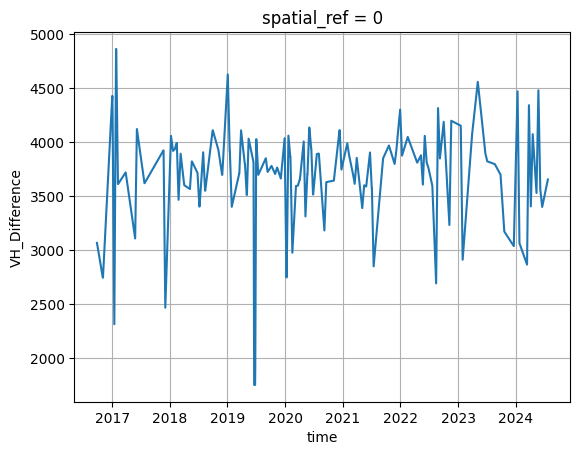

In [25]:
import matplotlib.pyplot as plt
ds.sum(dim='x').sum(dim='y').VH_Difference.plot()
plt.grid()

/tmp/ipykernel_136677/3785331004.py:29: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.xticks(pd.date_range(start=time.min(), end=time.max(), freq='6M'), rotation=45,
/tmp/ipykernel_136677/3785331004.py:30: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  labels=pd.date_range(start=time.min(), end=time.max(), freq='6M').strftime('%Y-%b'))


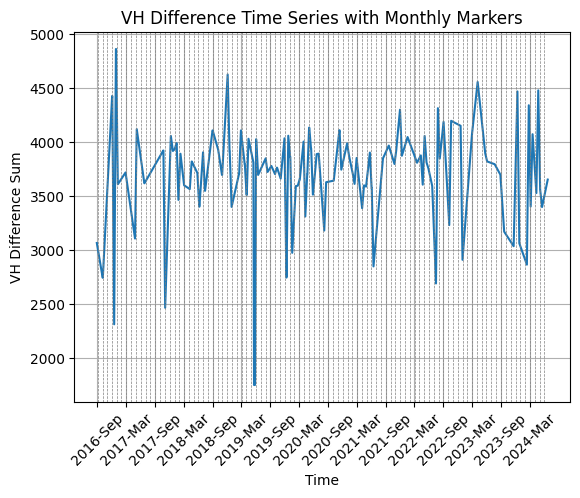

In [31]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'ds' is your xarray dataset with the time series data
# Sum over 'x' and 'y' dimensions and plot the 'VH_Difference' variable
vh_difference_sum = ds.sum(dim='x').sum(dim='y').VH_Difference

# Plot the time series
vh_difference_sum.plot()
plt.grid()

# Extract time coordinate from the dataset
time = vh_difference_sum['time'].values

# Convert time to pandas datetime for easier handling
time = pd.to_datetime(time)

# Add vertical lines for each month
for date in pd.date_range(start=time.min(), end=time.max(), freq='MS'):
    plt.axvline(date, color='gray', linestyle='--', linewidth=0.5)

# Optionally, you can also add shaded regions for each month
# for i in range(len(time) - 1):
#     plt.axvspan(time[i], time[i + 1], color='lightgray', alpha=0.3)

# Add labels for the months at the bottom of the plot
# plt.xticks(pd.date_range(start=time.min(), end=time.max(), freq='MS'), rotation=45)
# Add labels for the years and months at the bottom of the plot
plt.xticks(pd.date_range(start=time.min(), end=time.max(), freq='6M'), rotation=45, 
           labels=pd.date_range(start=time.min(), end=time.max(), freq='6M').strftime('%Y-%b'))

plt.title('VH Difference Time Series with Monthly Markers')
plt.xlabel('Time')
plt.ylabel('VH Difference Sum')
plt.show()

In [32]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks

# Assuming 'ds' is your xarray dataset with the time series data
# Sum over 'x' and 'y' dimensions to get the 'VH_Difference' variable
vh_difference_sum = ds.sum(dim='x').sum(dim='y').VH_Difference

# Extract time coordinate from the dataset
time = vh_difference_sum['time'].values

# Convert time to pandas datetime for easier handling
time = pd.to_datetime(time)

# Identify peaks in the VH_Difference data
peaks, _ = find_peaks(vh_difference_sum.values)

# Get the dates corresponding to the peaks
peak_dates = time[peaks]

# Print the dates of the peaks
print("Dates of Peaks in VH Difference:")
for date in peak_dates:
    print(date)

Dates of Peaks in VH Difference:
2017-01-01 00:00:00
2017-01-25 00:00:00
2017-03-27 00:00:00
2017-06-06 00:00:00
2017-11-21 00:00:00
2018-01-08 00:00:00
2018-02-13 00:00:00
2018-03-10 00:00:00
2018-05-20 00:00:00
2018-07-31 00:00:00
2018-09-29 00:00:00
2019-01-03 00:00:00
2019-03-28 00:00:00
2019-05-15 00:00:00
2019-07-02 00:00:00
2019-09-01 00:00:00
2019-10-07 00:00:00
2019-11-11 00:00:00
2019-12-29 00:00:00
2020-01-22 00:00:00
2020-04-28 00:00:00
2020-06-02 00:00:00
2020-08-01 00:00:00
2020-12-11 00:00:00
2021-01-29 00:00:00
2021-03-30 00:00:00
2021-05-16 00:00:00
2021-06-22 00:00:00
2021-10-20 00:00:00
2021-12-30 00:00:00
2022-02-16 00:00:00
2022-05-11 00:00:00
2022-06-04 00:00:00
2022-08-27 00:00:00
2022-10-02 00:00:00
2022-11-19 00:00:00
2023-05-06 00:00:00
2024-01-13 00:00:00
2024-03-25 00:00:00
2024-04-18 00:00:00
2024-05-24 00:00:00


In [35]:
ds.to_netcdf('austin_un_flood_2017_2024.nc')

In [36]:
ds

<xarray.Dataset> Size: 685MB
Dimensions:        (time: 155, x: 743, y: 744)
Coordinates:
  * time           (time) datetime64[ns] 1kB 2016-09-26 ... 2024-07-23
  * x              (x) float64 6kB -97.8 -97.8 -97.8 -97.8 ... -97.6 -97.6 -97.6
  * y              (y) float64 6kB 30.37 30.37 30.37 30.37 ... 30.17 30.17 30.17
    spatial_ref    int64 8B 0
Data variables:
    VH_Difference  (time, y, x) float64 685MB dask.array<chunksize=(1, 744, 743), meta=np.ndarray>
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    _FillValue:              -32768
    scale_factor:            1.0
    add_offset:              0.0

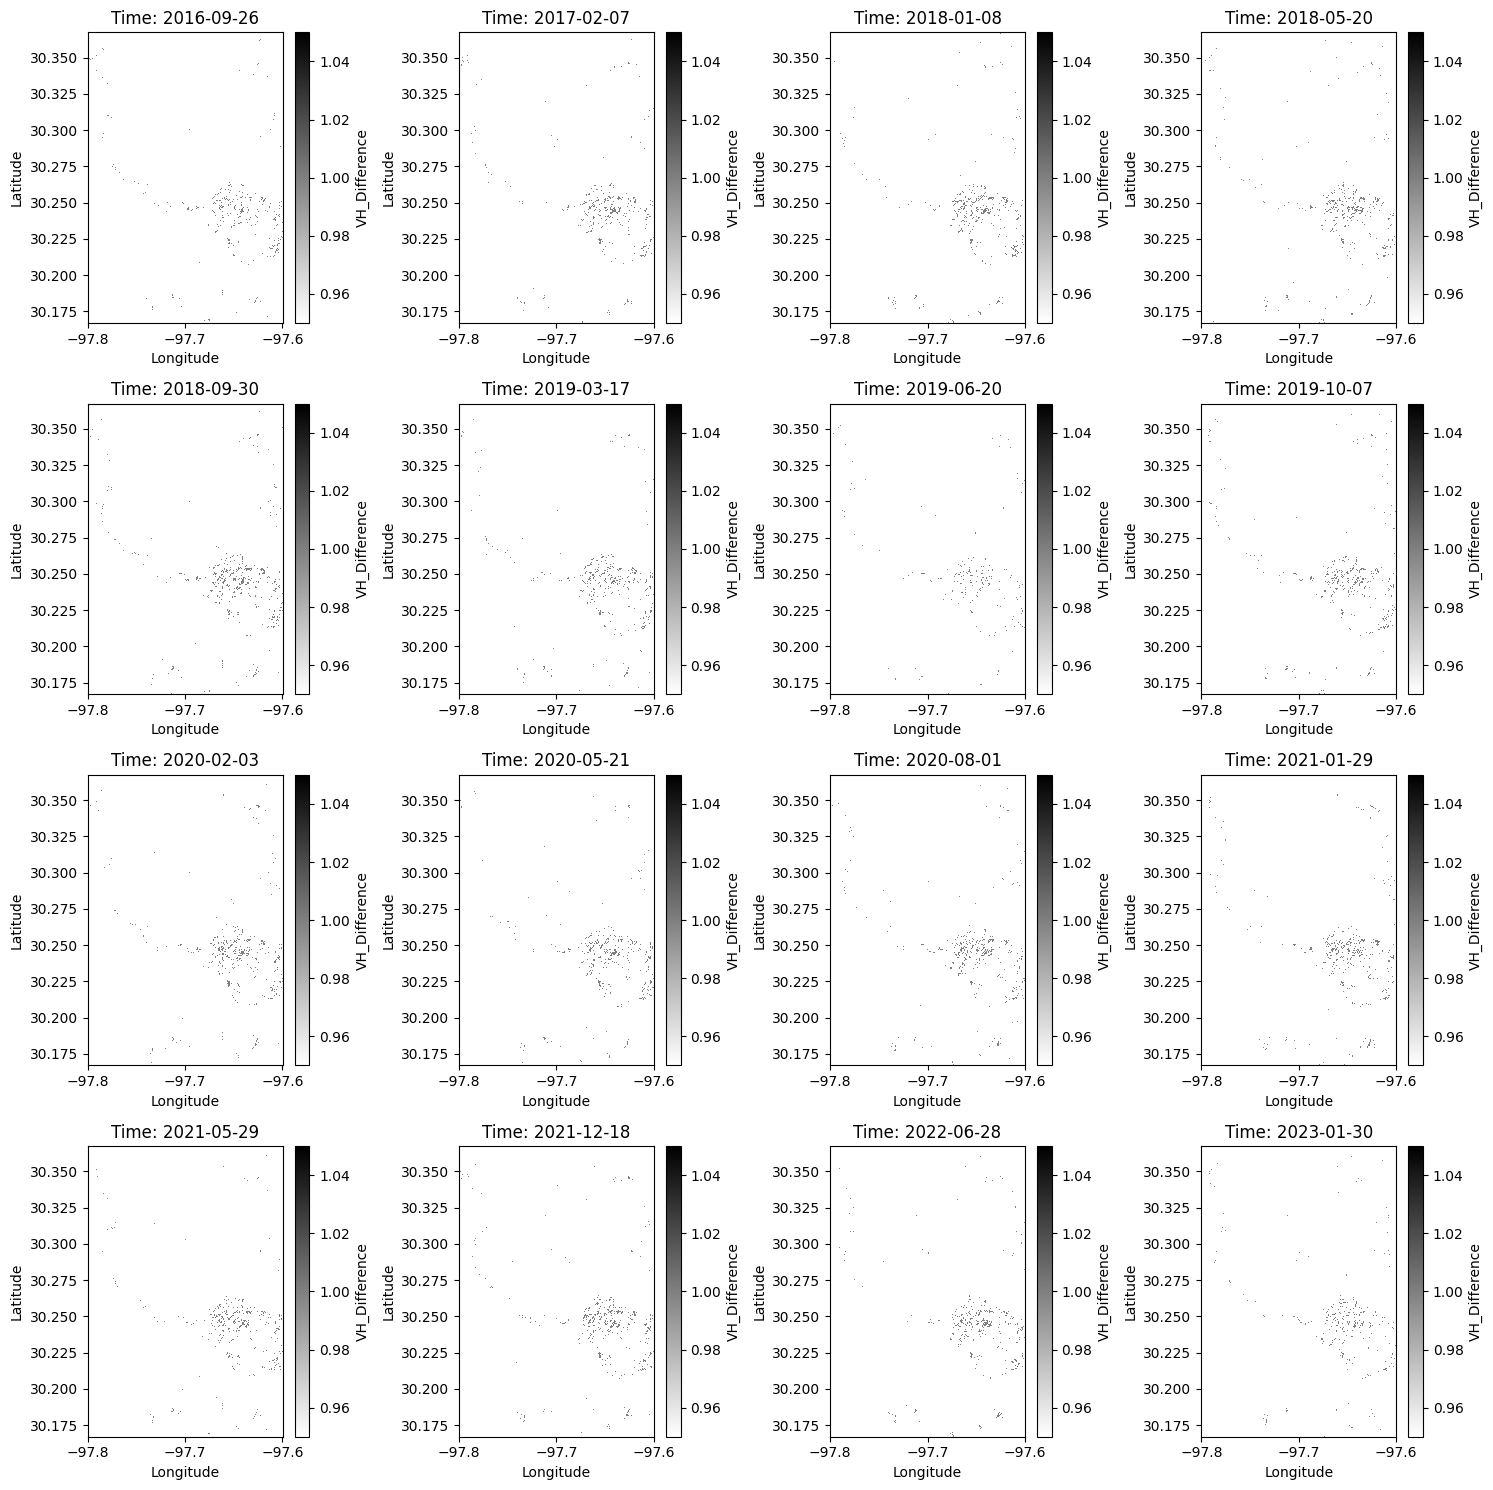

In [40]:
# Extract the data variable for plotting
data_var = 'VH_Difference'  # Change this to the actual variable name if different
times_to_plot = 16  # We want to plot 16 different times

# Selecting specific times evenly spaced for plotting
selected_times = ds['time'][::len(ds['time']) // times_to_plot]

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ds.sel(time=selected_times[i])[data_var].plot(ax=ax, cmap='binary')
    ax.set_title(f"Time: {str(selected_times[i].values)[:10]}")
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

plt.tight_layout()
plt.show()